In [4]:
import qdrant_client
import open_clip
from llama_index.core import (ServiceContext, 
                               SimpleDirectoryReader,
                               SimpleDirectoryReader,
                               StorageContext,
                               Settings)
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# load image documents from local directory
image_documents = SimpleDirectoryReader('E:/RAG_LLM/test/').load_data()

mm_model = OllamaMultiModal(model="llava")

In [5]:
mm_model

OllamaMultiModal(base_url='http://localhost:11434', model='llava', temperature=0.75, context_window=3900, request_timeout=None, additional_kwargs={})

In [6]:
response = mm_model.complete(prompt="what is in the image?", image_documents=image_documents)

In [7]:
response.text

" The image shows a street scene. There is a tree to the left and a building with a red fence in front of it. A few cars are parked along the side of the road, and there appears to be a blue sign or banner attached to one of the trees. The sky looks clear, suggesting good weather. There's no visible text on the image that would provide more context about the location or event. "

In [52]:
import matplotlib.pyplot as plt
import os
import io 
from PIL import Image 
import json

# Define a function to plot images given a list of image paths
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

In [8]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="E:/RAG_LLM/dataset/qdrant_mm_db_placepulse")

# if you only need image_store for image retrieval,
# you can remove text_sotre
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [9]:
# Load text and image documents from local folder
documents = SimpleDirectoryReader("E:/RAG_LLM/test_img/").load_data()
# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    show_progress=True
)

Parsing nodes:   0%|          | 0/52 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Generating image embeddings:   0%|          | 0/51 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [10]:
documents

[ImageDocument(id_='e79d7987-69e4-4346-8ae2-bb2441eedd7c', embedding=None, metadata={'file_path': 'E:\\RAG_LLM\\test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'file_name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'file_type': 'image/jpeg', 'file_size': 24316, 'creation_date': '2024-03-25', 'last_modified_date': '2024-03-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='E:\\RAG_LLM\\test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', image_url=None, image_mimetype=None, text_embedding=None),
 ImageDocument(id_='234e002

In [59]:
# Define the query string
query = "a car driving down a street next to a large bridge over a highway"

# Create a retriever engine using the MultiModalVectorStoreIndex
# Set the top-k parameters for text and image similarity
retriever_engine = index.as_retriever(similarity_top_k=3, image_similarity_top_k=3)

# Use the retriever engine to retrieve results for the given query
retrieval_results = retriever_engine.retrieve(query)

In [60]:
retrieval_results[3].node.metadata

{'file_path': 'E:\\RAG_LLM\\test_img\\1.314120_103.837886_50f561cbfdc9f065f000570b_Singapore.JPG',
 'file_name': '1.314120_103.837886_50f561cbfdc9f065f000570b_Singapore.JPG',
 'file_type': 'image/jpeg',
 'file_size': 24970,
 'creation_date': '2024-03-25',
 'last_modified_date': '2024-03-25'}

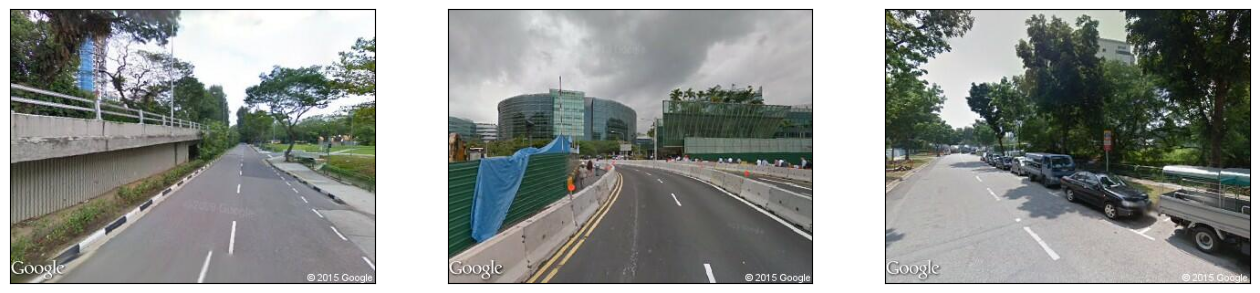

In [61]:
# Extract image paths from retrieval results metadata for images of type 'image/png'
image_paths = [
    retrieval_results[i].node.metadata['file_path']
    for i in range(len(retrieval_results))
    if retrieval_results[i].node.metadata['file_type'] == 'image/jpeg'
]
# plot the retrieved images
plot_images(image_paths)

In [62]:
image_paths

['E:\\RAG_LLM\\test_img\\1.314120_103.837886_50f561cbfdc9f065f000570b_Singapore.JPG',
 'E:\\RAG_LLM\\test_img\\1.333828_103.964356_50f56120fdc9f065f000543e_Singapore.JPG',
 'E:\\RAG_LLM\\test_img\\1.312001_103.867248_50f562e4fdc9f065f0005b87_Singapore.JPG']

In [65]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader

mm_model = OllamaMultiModal(model="llava")

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=mm_model, text_qa_template=qa_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

In [68]:
query_str = "a car on the road"
response = query_engine.query(query_str)

ResponseError: 

In [ ]:
response.response

In [ ]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [69]:
from llama_index.core import PromptTemplate

qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=mm_model, image_qa_template=qa_tmpl
)

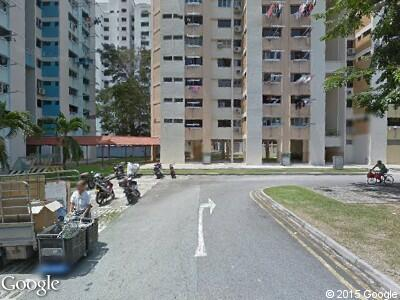

In [70]:
Image.open('E:/RAG_LLM/1.333658_103.918002_50f5619afdc9f065f00055c5_Singapore.JPG')

In [71]:
query_str = "scoring the beautiful form 0 to 10 based on provided content"
response = query_engine.image_query("1.333658_103.918002_50f5619afdc9f065f00055c5_Singapore.JPG", query_str)

ResponseError: 

In [82]:
response.response

" I'm unable to provide a rating or score based on the image alone, as beauty is highly subjective and can vary greatly between individuals. However, if you have specific criteria in mind for what makes a beautiful form (such as symmetry, balance, composition, etc.), I can comment on those aspects within the given context. For example, the image shows an urban street scene with buildings on either side. The presence of trees along the street adds greenery and a sense of nature to the cityscape. The road is lined with vehicles, suggesting activity in the area. There are traffic signs and markings indicating lane usage, which may contribute to the orderliness of the scene. The overcast sky gives a somewhat gloomy ambiance to the overall setting.\n\nIf you have specific questions about this image or need a critique based on certain design principles, feel free to ask! "

**Node ID:** 7c7c2301-5706-40ae-b182-6c65b8f83a47<br>**Similarity:** 0.8517636556204743<br>**Text:** <br>**Image:**

**Node ID:** 0535bee9-277f-4a18-8abe-42dd20518e7f<br>**Similarity:** 0.8507624950335615<br>**Text:** <br>**Image:**

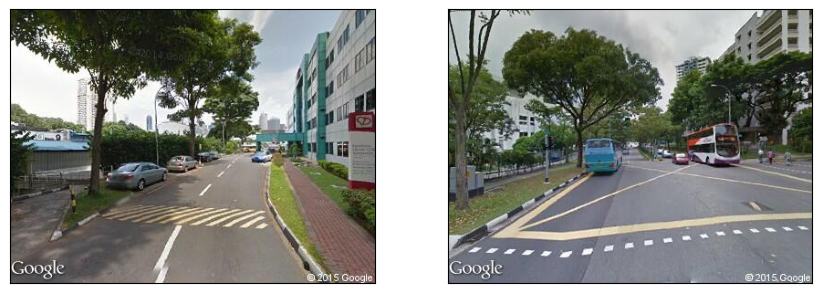

In [83]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["image_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)